### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category= DeprecationWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


### Loading Data

In [ ]:
def read_data(train_data, test_data):

  train_data = pd.read_csv(train_data)
  test_data = pd.read_csv(test_data)
  target_col = train_data['Loan_Status']
  # train_data.drop(columns = ['Loan_Status'],inplace=True)
  combine_df = train_data.append(test_data, ignore_index = True, sort = False)

  return train_data,test_data,combine_df,target_col

In [ ]:
train_data,test_data,combine_df,target_col = read_data('Datasets/train_ctrUa4K.csv','Datasets/test_lAUu6dG.csv')

In [ ]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### EDA

In [ ]:
target_col.isnull().sum()

0

In [ ]:
# train_data.drop(columns=['Loan_ID'],inplace = True)
train_data.isnull().sum(), train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


(Loan_ID               0
 Gender               13
 Married               3
 Dependents           15
 Education             0
 Self_Employed        32
 ApplicantIncome       0
 CoapplicantIncome     0
 LoanAmount           22
 Loan_Amount_Term     14
 Credit_History       50
 Property_Area         0
 Loan_Status           0
 dtype: int64, None)

In [ ]:
test_data.isnull().sum()

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


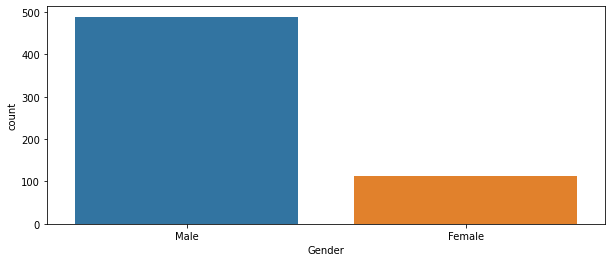

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


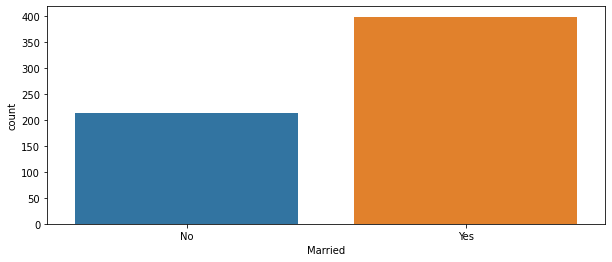

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


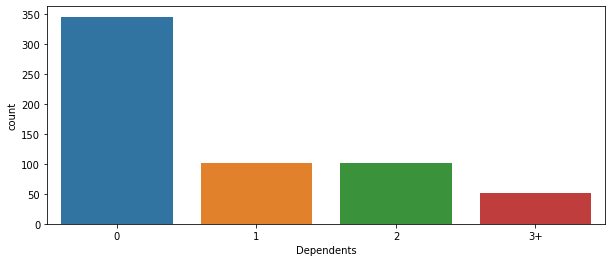

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


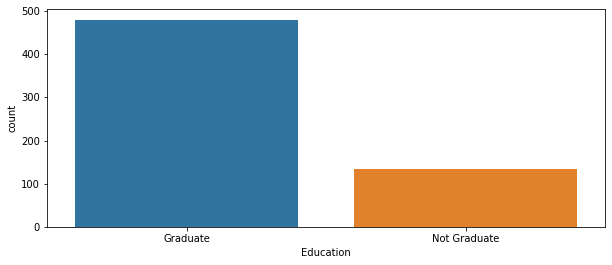

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


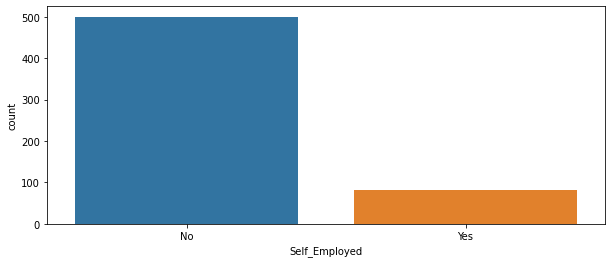

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


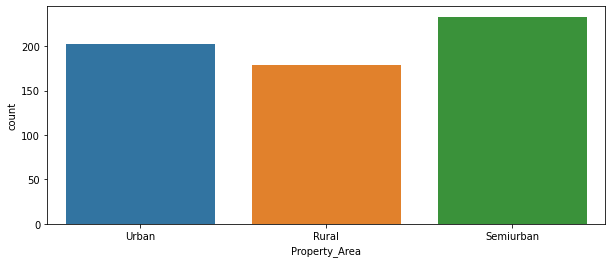

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


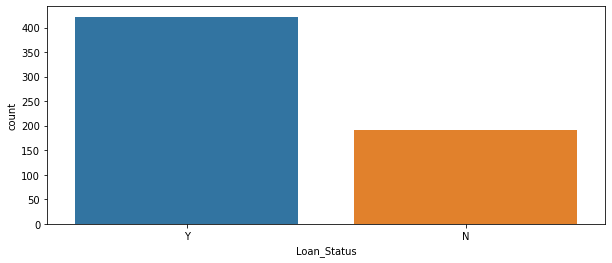

In [ ]:
cols = train_data.columns
obj_cols = train_data.select_dtypes('object').columns.values

obj_col_dataset = train_data[obj_cols]
obj_col_dataset.head()
# cols = combine_df.columns

# # cols
for col in obj_col_dataset.columns[1:]: 
  plt.figure(figsize = (10,4))
  sns.countplot(train_data[col])
  plt.xlabel(col)
  plt.show()


In [ ]:
numerical_dataset = train_data[train_data.columns[~train_data.columns.isin(obj_cols)].values]
numerical_dataset.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849,0.0,NaN,360.0,1.0
1,4583,1508.0,128.0,360.0,1.0
2,3000,0.0,66.0,360.0,1.0
3,2583,2358.0,120.0,360.0,1.0
4,6000,0.0,141.0,360.0,1.0


### Data Preprocessing and Feature Engineering

In [ ]:
def impute_values(df,test_df):

  df.Gender = df.Gender.fillna(df.Gender.mode().values[0])
  df.Married = df.Married.fillna(df.Married.mode().values[0])
  df.Dependents = df.Dependents.fillna('Unk')
  df.Self_Employed = df.Self_Employed.fillna('Unk')
  df.LoanAmount = df.LoanAmount.fillna(df.LoanAmount.median())
  df.Loan_Amount_Term = df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.median())
  df.Credit_History = df.Credit_History.fillna(2)
  df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
  df = df.drop(['ApplicantIncome','CoapplicantIncome'], axis=1)
  

  test_df.Gender = test_df.Gender.fillna(df.Gender.mode().values[0])
  test_df.Married = test_df.Married.fillna(df.Married.mode().values[0])
  test_df.Dependents = test_df.Dependents.fillna('Unk')
  test_df.Self_Employed = test_df.Self_Employed.fillna('Unk')
  test_df.LoanAmount = test_df.LoanAmount.fillna(df.LoanAmount.median())
  test_df.Loan_Amount_Term = test_df.Loan_Amount_Term.fillna(df.Loan_Amount_Term.median())
  test_df.Credit_History = test_df.Credit_History.fillna(2)
  test_df['Total_Income'] = test_df['ApplicantIncome'] + test_df['CoapplicantIncome']
  test_df = test_df.drop(['ApplicantIncome','CoapplicantIncome'], axis=1)

  return df,test_df
# columns[0]

In [ ]:
imputed_train_data,imputed_test_data = impute_values(train_data,test_data)

In [ ]:
imputed_test_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income
0,LP001015,Male,Yes,0,Graduate,No,110.0,360.0,1.0,Urban,5720
1,LP001022,Male,Yes,1,Graduate,No,126.0,360.0,1.0,Urban,4576
2,LP001031,Male,Yes,2,Graduate,No,208.0,360.0,1.0,Urban,6800
3,LP001035,Male,Yes,2,Graduate,No,100.0,360.0,2.0,Urban,4886
4,LP001051,Male,No,0,Not Graduate,No,78.0,360.0,1.0,Urban,3276


In [ ]:
from sklearn.preprocessing import LabelEncoder

def preprocessing(df,df_test):

  le = LabelEncoder()
  df['Dependents'] = le.fit_transform(df['Dependents'])
  df_test['Dependents'] = le.fit_transform(df_test['Dependents'])


  df['Gender'] = df['Gender'].map({'Male':1,'Female':0})
  df_test['Gender'] = df_test['Gender'].map({'Male':1,'Female':0})

  df['Married'] = df['Married'].map({'Yes':1,'No':0})
  df_test['Married'] = df_test['Married'].map({'Yes':1,'No':0})

  df['Education'] = df['Education'].map({'Graduate': 1, 'Not Graduate':0})
  df_test['Education'] = df_test['Education'].map({'Graduate': 1, 'Not Graduate':0})

  # df.drop(['Dependents'], axis=1, inplace=True)
  
  df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No':0, 'Unk':2})
  df_test['Self_Employed'] = df_test['Self_Employed'].map({'Yes': 1, 'No':0, 'Unk':2})
  
  df['Property_Area'] = df['Property_Area'].map({'Rural':0,'Semiurban': 1, 'Urban':2})
  df_test['Property_Area'] = df_test['Property_Area'].map({'Rural':0,'Semiurban': 1, 'Urban':2})
  
  return df,df_test           
                  

In [ ]:
label_encoded_train_data, label_encoded_test_data= preprocessing(imputed_train_data,imputed_test_data)
label_encoded_train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,1,0,0,1,0,128.0,360.0,1.0,2,Y,5849.0
1,LP001003,1,1,1,1,0,128.0,360.0,1.0,0,N,6091.0
2,LP001005,1,1,0,1,1,66.0,360.0,1.0,2,Y,3000.0
3,LP001006,1,1,0,0,0,120.0,360.0,1.0,2,Y,4941.0
4,LP001008,1,0,0,1,0,141.0,360.0,1.0,2,Y,6000.0


In [ ]:
def creating_bins(df,df_test):
  df['below_10_years'] = df['Loan_Amount_Term'].map(lambda x: 1 if x<=120 else 0)
  df['10-20_years'] = df['Loan_Amount_Term'].map(lambda x: 1 if x>120 and x<=240 else 0)
  df['20+years'] = df['Loan_Amount_Term'].map(lambda x: 1 if  x>240 else 0)
  df.drop(['Loan_Amount_Term'], axis=1, inplace=True)

  df['Credit_History_Bad'] = df['Credit_History'].map(lambda x: 1 if x==0 else 0)
  df['Credit_History_Good'] = df['Credit_History'].map(lambda x: 1 if x==1 else 0)
  df['Credit_History_Unk'] = df['Credit_History'].map(lambda x: 1 if x==2 else 0)
  df.drop('Credit_History', axis=1, inplace=True)


  df_test['below_10_years'] = df_test['Loan_Amount_Term'].map(lambda x: 1 if x<=120 else 0)
  df_test['10-20_years'] = df_test['Loan_Amount_Term'].map(lambda x: 1 if x>120 and x<=240 else 0)
  df_test['20+years'] = df_test['Loan_Amount_Term'].map(lambda x: 1 if  x>240 else 0)
  df_test.drop(['Loan_Amount_Term'], axis=1, inplace=True)

  df_test['Credit_History_Bad'] = df_test['Credit_History'].map(lambda x: 1 if x==0 else 0)
  df_test['Credit_History_Good'] = df_test['Credit_History'].map(lambda x: 1 if x==1 else 0)
  df_test['Credit_History_Unk'] = df_test['Credit_History'].map(lambda x: 1 if x==2 else 0)
  df_test.drop('Credit_History', axis=1, inplace=True)

  return df,df_test


In [ ]:
df,df_test = creating_bins(label_encoded_train_data, label_encoded_test_data)

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Property_Area,Loan_Status,Total_Income,below_10_years,10-20_years,20+years,Credit_History_Bad,Credit_History_Good,Credit_History_Unk
0,LP001002,1,0,0,1,0,128.0,2,Y,5849.0,0,0,1,0,1,0
1,LP001003,1,1,1,1,0,128.0,0,N,6091.0,0,0,1,0,1,0
2,LP001005,1,1,0,1,1,66.0,2,Y,3000.0,0,0,1,0,1,0
3,LP001006,1,1,0,0,0,120.0,2,Y,4941.0,0,0,1,0,1,0
4,LP001008,1,0,0,1,0,141.0,2,Y,6000.0,0,0,1,0,1,0


In [ ]:
def preprocessing3(df,df_test):


  df['LoanAmount'] = df['LoanAmount']*1000
  df['Debt_Income_ratio'] = df['LoanAmount']/df['Total_Income']
  # df['Debt_Income_ratio'] = np.sqrt(df['Debt_Income_ratio'])
  df.drop(columns=['Total_Income','LoanAmount'],inplace=True)
  # df.Debt_Income_ratio = np.round(df.Debt_Income_ratio)


  df_test['LoanAmount'] = df_test['LoanAmount']*1000
  df_test['Debt_Income_ratio'] = df_test['LoanAmount']/df_test['Total_Income']
  # df_test['Debt_Income_ratio'] = np.sqrt(df_test['Debt_Income_ratio'])
  df_test.drop(columns=['Total_Income','LoanAmount'],inplace=True)
  # df.Debt_Income_ratio = np.round(df.Debt_Income_ratio)


In [ ]:
preprocessing3(df,df_test)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,below_10_years,10-20_years,20+years,Credit_History_Bad,Credit_History_Good,Credit_History_Unk,Debt_Income_ratio
0,LP001002,1,0,0,1,0,2,Y,0,0,1,0,1,0,21.884083
1,LP001003,1,1,1,1,0,0,N,0,0,1,0,1,0,21.014612
2,LP001005,1,1,0,1,1,2,Y,0,0,1,0,1,0,22.000000
3,LP001006,1,1,0,0,0,2,Y,0,0,1,0,1,0,24.286582
4,LP001008,1,0,0,1,0,2,Y,0,0,1,0,1,0,23.500000


### Modeling

In [ ]:
y = target_col
y.head()

0    Y
1    N
2    Y
3    Y
4    Y
Name: Loan_Status, dtype: object

In [ ]:
X = df.drop(columns=['Loan_ID','Loan_Status'])
X.head()


,Gender,Married,Dependents,Education,Self_Employed,Property_Area,below_10_years,10-20_years,20+years,Credit_History_Bad,Credit_History_Good,Credit_History_Unk,Debt_Income_ratio
0,1,0,0,1,0,2,0,0,1,0,1,0,21.884083
1,1,1,1,1,0,0,0,0,1,0,1,0,21.014612
2,1,1,0,1,1,2,0,0,1,0,1,0,22.000000
3,1,1,0,0,0,2,0,0,1,0,1,0,24.286582
4,1,0,0,1,0,2,0,0,1,0,1,0,23.500000


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.1, random_state = 42)
# X_train, X_val, y_train, y_val = train_test_split(X_smote,y_smote,test_size = 0.2, random_state = 42)


In [ ]:
def get_feature_importance(model,df):
  """
  model : The fitted model

  df : DataFrame that is used for fitting the model
  
  """
  features = pd.DataFrame()
  features['Feature'] = df.columns
  features['Importance'] = model.feature_importances_
  features.sort_values(by=['Importance'], ascending=False, inplace=True)
  cols = features['Feature']
  features.set_index('Feature', inplace=True)
  features.plot(kind='bar', figsize=(10, 5))
  return cols 

In [ ]:
# X.isnull().sum()

              precision    recall  f1-score   support

           N       0.88      0.33      0.48        21
           Y       0.74      0.98      0.84        41

    accuracy                           0.76        62
   macro avg       0.81      0.65      0.66        62
weighted avg       0.79      0.76      0.72        62



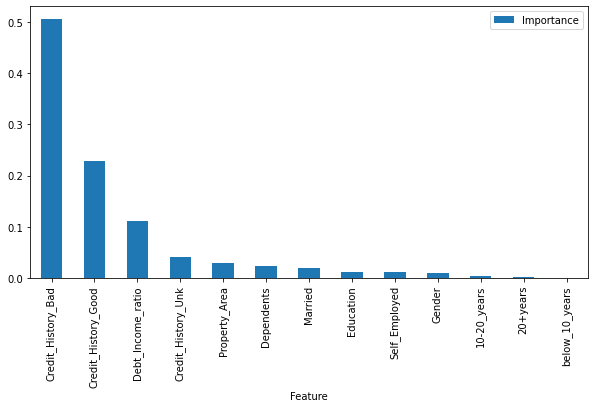

In [ ]:

rf_model =  RandomForestClassifier(bootstrap= False,
              min_samples_leaf= 3,
              n_estimators= 50,
              min_samples_split= 10,
              max_features= 'sqrt',
              max_depth= 6)

rf_model.fit(X_train,y_train)
imp_cols = get_feature_importance(rf_model,X_train)
# print(imp_cols[:5])
rf_model.fit(X_train,y_train)

print(classification_report(y_val, rf_model.predict(X_val)))


In [ ]:
lr_model =  LogisticRegression(C=0.4)

# imp_cols = get_feature_importance(rf_model,X_train)
# lr_model.fit(X_train,y_train)
lr_model.fit(X_train,y_train)

print(classification_report(y_val, lr_model.predict(X_val)))


              precision    recall  f1-score   support

           N       0.88      0.33      0.48        21
           Y       0.74      0.98      0.84        41

    accuracy                           0.76        62
   macro avg       0.81      0.65      0.66        62
weighted avg       0.79      0.76      0.72        62



              precision    recall  f1-score   support

           N       0.89      0.38      0.53        21
           Y       0.75      0.98      0.85        41

    accuracy                           0.77        62
   macro avg       0.82      0.68      0.69        62
weighted avg       0.80      0.77      0.74        62



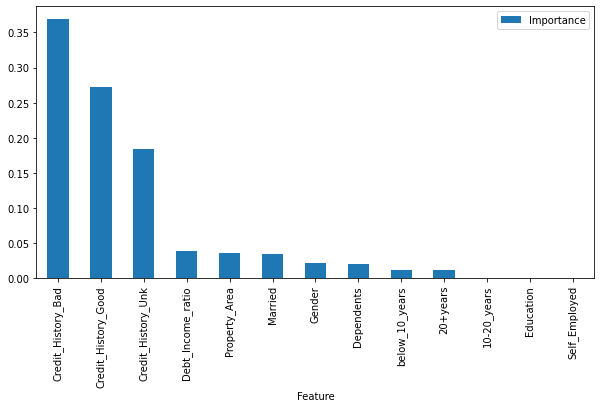

In [ ]:
xgb_model=xgb.XGBClassifier(
  learning_rate =0.01,
# booster = 'gblinear',
 n_estimators=200,
 max_depth=2,
#  min_child_weight=1,
#  gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
# #  objective= '',
#  nthread=5,
#  scale_pos_weight=1,
#  seed=27,reg_alpha =0.01
 )
xgb_model.fit(X_train,y_train)
imp_cols = get_feature_importance(xgb_model,X_train)
# xgb_model.fit(X_train[imp_cols[:6]],y_train)
print(classification_report(y_val, xgb_model.predict(X_val)))

# print(classification_report(y_val, xgb_model.predict(X_val[imp_cols[:6]])))


In [ ]:

lgb_model= GradientBoostingClassifier(n_estimators=500,n_iter_no_change=50,learning_rate=0.01,random_state=42,max_depth=2)

lgb_model.fit(X_train, y_train)


print(classification_report(y_val, lgb_model.predict(X_val)))


              precision    recall  f1-score   support

           N       0.91      0.48      0.62        21
           Y       0.78      0.98      0.87        41

    accuracy                           0.81        62
   macro avg       0.85      0.73      0.75        62
weighted avg       0.83      0.81      0.79        62



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
# X_train, X_val, y_train, y_val = train_test_split( X,  y, train_size = 0.8,random_state =42)
# X_train, X_val, y_train, y_val = train_test_split( tfidf_lemm,  y, train_size = 0.8,random_state =42)

knc.fit(X_train,y_train)


print(classification_report(y_val, knc.predict(X_val)))

              precision    recall  f1-score   support

           N       0.71      0.48      0.57        21
           Y       0.77      0.90      0.83        41

    accuracy                           0.76        62
   macro avg       0.74      0.69      0.70        62
weighted avg       0.75      0.76      0.74        62



In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[('lgbmc', lgb_model),('knc', knc),('xgbc', xgb_model),('logreg',lr_model),('rf_model',rf_model)],voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)  
preds = voting_clf.predict(X_val)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
labels = {'N':0,'Y':1}
 
print("Accuracy is: " , accuracy_score(y_val, preds))
print("F1 Score is: " , f1_score(y_val.map(labels), pd.Series(preds).map(labels)))

Accuracy is:  0.7580645161290323
F1 Score is:  0.8421052631578947


In [ ]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,below_10_years,10-20_years,20+years,Credit_History_Bad,Credit_History_Good,Credit_History_Unk,Debt_Income_ratio
0,LP001015,1,1,0,1,0,2,0,0,1,0,1,0,19.230769
1,LP001022,1,1,1,1,0,2,0,0,1,0,1,0,27.534965
2,LP001031,1,1,2,1,0,2,0,0,1,0,1,0,30.588235
3,LP001035,1,1,2,1,0,2,0,0,1,0,0,1,20.466639
4,LP001051,1,0,0,0,0,2,0,0,1,0,1,0,23.809524


In [ ]:
pred_x = df_test.drop(columns = ['Loan_ID'])
# predictions = lr_model.predict(pred_x[imp_cols[:8]])
# predictions = rf_model.predict(pred_x)
predictions = voting_clf.predict(pred_x)
# predictions = lgb_model.predict(pred_x)

x_sub = pd.DataFrame({'Loan_ID':df_test['Loan_ID'],'Loan_Status':predictions})
x_sub.head()


,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [ ]:
x_sub.to_csv('sub1.csv',index = 0)
